        E:\Data\FinalResults\Dsp\0852 - Dynamic Trajectorys over Speed-Dist Plane is already existed!


C:\Users\12454\AppData\Local\Temp\ipykernel_22316\813517556.py:76: RuntimeWarning: Mean of empty slice
  interm_m = np.nanmean(interm_m, axis=0)


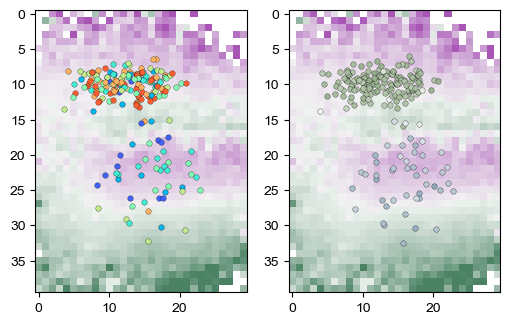

In [9]:
from mylib.statistic_test import *

code_id = "0852 - Dynamic Trajectorys over Speed-Dist Plane"
loc = join(figpath, "Dsp", code_id)
mkdir(loc)

dir_name0 = join(figpath, "Dsp", "0844 - Manifold of Initialization")
dir_name1 = join(figpath, "Dsp", "0850 - Lisa Paper Revisits")

def get_transient_map(mouse: int):
    if exists(join(dir_name1, f"transient_{mouse}.pkl")):
        with open(join(dir_name1, f"transient_{mouse}.pkl"), "rb") as f:
            return pickle.load(f)
    else:
        raise FileNotFoundError(
            f"Please run Fig0850 - Lisa Paper Revisits.ipynb first "
            f"to generate transient_{mouse}.pkl"
        )
    
def _get_speed_dist_mat(mouse, session = None, is_shuffle: bool = False):
    (
        kmeans_dist_traj, 
        neural_traj, 
        session_traj, 
        old_pos_traj, 
        route_traj, 
        lap_traj, 
        pos_traj, 
        speed_traj
    ) = get_transient_map(mouse)

    if is_shuffle:
        idx0 = np.arange(kmeans_dist_traj.shape[0])#np.random.permutation(speed_traj.shape[0])
        kmeans_dist_traj = np.roll(kmeans_dist_traj, np.random.randint(speed_traj.shape[0]))
        speed_traj = speed_traj[idx0]
    else:
        idx0 = np.arange(kmeans_dist_traj.shape[0])
        idx1 = np.arange(kmeans_dist_traj.shape[0])


    if session is None:
        return scipy.stats.binned_statistic_2d(
                x=speed_traj[:-1],
                y=kmeans_dist_traj[:-1],
                values=[
                    np.arctan2(
                        np.ediff1d(kmeans_dist_traj), 
                        np.ediff1d(speed_traj)
                    ),
                    np.ediff1d(kmeans_dist_traj)
                ],
                statistic='mean',
                bins=[30, 40],
                range=np.array([[0, 60], [-2, 2]])
            )[0]
    else:
        return scipy.stats.binned_statistic_2d(
            x=speed_traj[session_traj == session][:-1],
            y=kmeans_dist_traj[session_traj == session][:-1],
            values=[
                np.arctan2(
                    np.ediff1d(kmeans_dist_traj[session_traj == session]), 
                    np.ediff1d(speed_traj[session_traj == session])
                ), 
                np.ediff1d(kmeans_dist_traj[session_traj == session])
            ],
            statistic='mean',
            bins=[30, 40],
            range=np.array([[0, 60], [-2, 2]])
        )[0]

from scipy.ndimage import gaussian_filter
def get_speed_dist_mat(mouse, is_shuffle: bool = False, is_all = False):
    if is_all:
        interm_m = np.stack([_get_speed_dist_mat(mouse, is_shuffle=is_shuffle) for mouse in [10212, 10224, 10227, 10232]], axis=0)
        interm_m = np.nanmean(interm_m, axis=0)
    else:
        interm_m = _get_speed_dist_mat(mouse, is_shuffle=is_shuffle)
        
    idx0 = np.where(np.isnan(interm_m[0]))
    idx1 = np.where(np.isnan(interm_m[1]))
    interm_m[np.isnan(interm_m)] = 0
    theta, mat = interm_m[0, :, :], interm_m[1, :, :]
    theta = gaussian_filter(theta, 0.5)
    mat = gaussian_filter(mat, 0.5)
    theta[idx0] = np.nan
    mat[idx1] = np.nan
    
    return mat
    
if __name__ == '__main__':
    
    mouse = 10232
    mat = get_speed_dist_mat(mouse=mouse, is_all=True).T
    cs = sns.color_palette("rainbow", 7)
    
    fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(6, 4))
    ax = axes[0]
    ax1 = axes[1]
    ax.imshow(mat, vmin=-0.5, vmax=0.5, cmap=sns.diverging_palette(145, 300, s=60, as_cmap=True))    
    ax1.imshow(mat, vmin=-0.5, vmax=0.5, cmap=sns.diverging_palette(145, 300, s=60, as_cmap=True))    
    
    for mouse in [10212, 10224, 10227, 10232]:
        (
        kmeans_dist_traj, 
        neural_traj, 
        session_traj, 
        old_pos_traj, 
        route_traj, 
        lap_traj, 
        pos_traj, 
        speed_traj
        ) = get_transient_map(mouse)
    
        beg = np.concatenate([[0], np.where(np.ediff1d(lap_traj)!=0)[0]+1])
        end = np.concatenate([np.where(np.ediff1d(lap_traj)!=0)[0]+1, [lap_traj.shape[0]]])
    
        selected_idx = np.where(np.isin(route_traj[beg], [6]))[0]
        selected_beg, selected_end = beg[selected_idx], end[selected_idx]
        
        colors = palette = sns.diverging_palette(h_neg=120, h_pos=240, s=80, l=38, as_cmap=True, sep=20)(np.clip((kmeans_dist_traj + 2)/4, 0, 1-1e-8))
        kmeans_dist_traj = np.clip(((kmeans_dist_traj+2) // 0.1).astype(np.int64), 0, 39)
        speed_traj = np.clip((speed_traj // 2).astype(np.int64), 0, 29)
        
        
        for i in range(len(selected_idx)):
            beg_idx, end_idx = selected_beg[i], selected_end[i]

            #ax.plot(speed_traj[beg_idx:end_idx], kmeans_dist_traj[beg_idx:end_idx])
            ax.plot(
                speed_traj[beg_idx:beg_idx+1]+np.random.rand()-1, 
                kmeans_dist_traj[beg_idx:beg_idx+1]+np.random.rand()-1, 
                'o', 
                c=cs[session_traj[beg_idx]], 
                markersize=4, 
                markeredgecolor='k', 
                markeredgewidth=0.2
            )
            c = sns.diverging_palette(h_neg=120, h_pos=240, s=80, l=38, as_cmap=True, sep=20)(np.clip(np.median(kmeans_dist_traj[beg_idx:end_idx])/39, 0, 1-1e-8))
            ax1.plot(
                speed_traj[beg_idx:beg_idx+1]+np.random.rand()-1, 
                kmeans_dist_traj[beg_idx:beg_idx+1]+np.random.rand()-1, 
                'o', 
                c=c, 
                markersize=4, 
                markeredgecolor='k', 
                markeredgewidth=0.2
            )
    plt.show()